# Section 0 (Preliminaries)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor



import os
os.makedirs("outputs/figures", exist_ok=True)
os.makedirs("outputs/tables", exist_ok=True)

def save_output(obj, name, kind="figure"):
    """
    Save figures or tables to the outputs folder.

    Parameters:
        obj  : matplotlib figure OR pandas DataFrame
        name : str, filename without extension
        kind : "figure" or "table"
    """
    if kind == "figure":
        # If obj is a matplotlib Figure, save directly
        if hasattr(obj, "savefig"):
            obj.savefig(f"outputs/figures/{name}.png", dpi=300, bbox_inches="tight")
        else:
            # fallback: save current plt figure
            plt.savefig(f"outputs/figures/{name}.png", dpi=300, bbox_inches="tight")
        plt.close()

    elif kind == "table":
        # Assume it's a pandas DataFrame
        obj.to_csv(f"outputs/tables/{name}.csv", index=False)
    elif kind == "summary":
        # statsmodels summary
        with open(f"outputs/tables/{name}.txt", "w") as f:
            f.write(obj.as_text())

    else:
        raise ValueError("kind must be 'figure' or 'table'")

    print(f"✅ Saved {kind}: {name}")

In [2]:
advertising = pd.read_csv("Advertising.csv")
advertising.rename(columns={'Unnamed: 0': 'CampaignID'}, inplace=True)
advertising.head()

,CampaignID,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


# Section 1 (EDA)

In [3]:
advertising.dtypes

,0
CampaignID,int64
TV,float64
radio,float64
newspaper,float64
sales,float64


In [4]:
cols_quant = ['TV','radio','newspaper','sales']
advertising_quant = advertising[cols_quant]
advertising_scatter = pd.plotting.scatter_matrix(advertising_quant, figsize=(10, 10), diagonal = 'kde')
save_output(advertising_scatter, "scatter_matrix")

✅ Saved figure: scatter_matrix


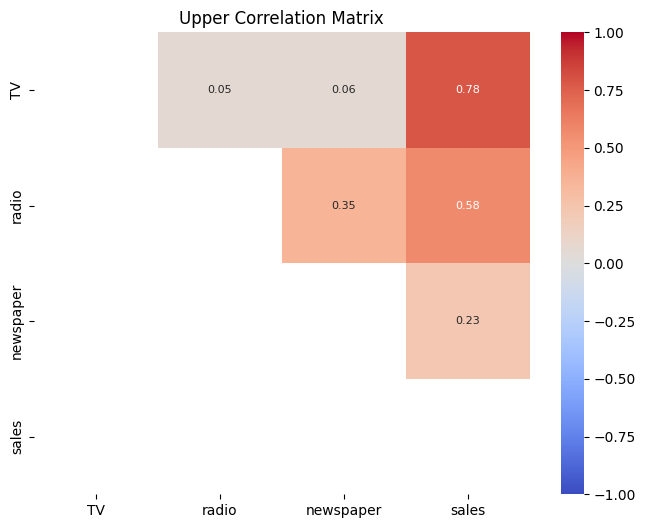

✅ Saved figure: upper_corr_matrix


In [5]:
corr_matrix = advertising_quant.corr()

mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

upper_tri = corr_matrix.mask(mask)

fig, ax = plt.subplots(figsize = (8,6))

sns.heatmap(corr_matrix, vmin = -1.0, vmax = 1.0, mask = mask, annot=True, fmt = '.2f', cmap = 'coolwarm', annot_kws = {'size':8}, ax = ax)

ax.set_title("Upper Correlation Matrix")

plt.show()
save_output(fig, "upper_corr_matrix")

# Section 2 (Forward Selection)

In [6]:
Y = advertising['sales']

X1 = advertising['TV']
X2 = advertising['radio']
X3 = advertising['newspaper']

model1 = sm.OLS(Y, sm.add_constant(X1)).fit()
model2 = sm.OLS(Y, sm.add_constant(X2)).fit()
model3 = sm.OLS(Y, sm.add_constant(X3)).fit()

beta1 = model1.params #this gives the betas
bse1 = model1.bse #bse means "beta standard error"
tstat1 = model1.tvalues #tstat means "t-statistic"
pval1 = model1.pvalues #pval means "p-value"
R2 = model1.rsquared #R2 means "R-squared"
RMSE = np.sqrt(mean_squared_error(Y, model1.predict(sm.add_constant(X1)))) #Residual standard error
F = model1.fvalue #F-statistic

results_table1 = pd.DataFrame({
    "Coefficient": model1.params,
    "Std. Error": model1.bse,
    "t-Statistic": model1.tvalues,
    "p-Value": model1.pvalues,
    "R-Squared": R2,
    "RMSE": RMSE,
    "F-Statistic": F
})

print(results_table1)


beta2 = model2.params
bse2 = model2.bse
tstat2 = model2.tvalues
pval2 = model2.pvalues
beta3 = model3.params
bse3 = model3.bse
tstat3 = model3.tvalues
pval3 = model3.pvalues

results_table2 = pd.DataFrame({
    "Coefficient": model2.params,
    "Std. Error": model2.bse,
    "t-Statistic": model2.tvalues,
    "p-Value": model2.pvalues
})

results_table3 = pd.DataFrame({
    "Coefficient": model3.params,
    "Std. Error": model3.bse,
    "t-Statistic": model3.tvalues,
    "p-Value": model3.pvalues
})

print(results_table2)
print(results_table3)

#print(model2.params)
#print(model2.bse)
#print(model3.params)
#print(model3.bse)
save_output(results_table1, "TV Advertising on Sales")
save_output(results_table2, "Radio Advertising on Sales")
save_output(results_table3, "Newspaper Advertising on Sales")

       Coefficient  Std. Error  t-Statistic       p-Value  R-Squared  \
const     7.032594    0.457843    15.360275  1.406300e-35   0.611875   
TV        0.047537    0.002691    17.667626  1.467390e-42   0.611875   

           RMSE  F-Statistic  
const  3.242322   312.144994  
TV     3.242322   312.144994  
       Coefficient  Std. Error  t-Statistic       p-Value
const     9.311638    0.562900    16.542245  3.561071e-39
radio     0.202496    0.020411     9.920765  4.354966e-19
           Coefficient  Std. Error  t-Statistic       p-Value
const        12.351407    0.621420    19.876096  4.713507e-49
newspaper     0.054693    0.016576     3.299591  1.148196e-03
✅ Saved figure: TV Advertising on Sales
✅ Saved figure: Radio Advertising on Sales
✅ Saved figure: Newspaper Advertising on Sales


We are seeking evidence that the slope, obtained as an estimate of beta1, is sufficiently far from 0 that we can be confident that the actual beta1 is nonzero.  For the model $y = \beta_0 + \beta_1 X + \epsilon$ with $\epsilon \sim N(0,\sigma^2)$ and estimate $\beta_1$, we have the following:

$$SE(\hat{\beta}_1)^2 = \frac{\sigma^2}{\sum_{i=1}^{n}(x_i - \overline{x})^2}$$

$$T_{n} = \frac{|\hat{\beta}_1 - 0|}{SE(\hat{\beta}_1)}$$

$$RSE^2 = \frac{1}{n-2} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$ where $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i.$

$$RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

If $\hat{y}_i$ is close to $y_i$ for all $n$ samples, then RSS and RSE will be small, and the model is a good fit.

To compute $R^2$ from the data, we first compute the average $\overline{y} = \sum_{i=1}^{n}y_i.$  Then the total sum of squares is $$TSS = \sum_{i=1}^{n}(y_i - \overline{y})^2.$$ No regression is performed here!  Then $$R^2 = 1 - \frac{RSS}{TSS}.$$  This measures the proportion of TSS that is explained using X.  It is equivalent to the square of the correlation between the actual $Y$ and the predicted $\hat{Y}.$  (Use capital letters to denote the random variable *before* the data is collected.)

In [7]:
Y = advertising['sales']
X = advertising.drop(columns = ['sales','CampaignID'])

model = sm.OLS(Y,sm.add_constant(X)).fit() #can use sm.OLS when X is a matrix
print(model.summary(title = 'OLS Regression:  Three Features'))
save_output(model.summary(title = "OLS Regression: Three Features"), "OLS Regression: Three Features", kind = 'summary')
maxp = model.pvalues.max()
X2 = X.drop(columns = model.pvalues[model.pvalues == maxp].index)
model2 = sm.OLS(Y,sm.add_constant(X2)).fit()
print(model2.summary(title = 'OLS Regression: Max Feature Dropped'))
save_output(model.summary(title = "OLS Regression: Max Feature Dropped"), "OLS Regression: Max Feature Dropped", kind = 'summary')

                       OLS Regression:  Three Features                        
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Thu, 04 Sep 2025   Prob (F-statistic):           1.58e-96
Time:                        20:30:30   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

For a multiple regression, the null hypothesis is that all slopes $\beta_1,...,\beta_p$ are all equal to $0$.  The alternatie hypothesis is that at least one of the $\beta_j$ is non-zero.  The hypothesis test is computed using the F-statistic: $$F = \frac{(TSS-RSS)/p}{RSS/(n-p-1)}$$ where $TSS = \sum_{i=1}^{n}(y_i - \overline{y})^2$ and $RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$.  An F-statistic of 570 is much larger than 1, so there is compelling evidence to reject the null hypothesis.

F-statistic fails when the number of predictors p is small compared to the sample size n.

Backward selection is performed on the data.  It is determined that newspapers has the largest p-value, so it is dropped from the dataset to obtain X2.  All remaining p-values are smaller, and the F-statistic increases to 859.6.  Backward selection cannot be used if the number of predictors is greater than the sample size.

Adding an interaction term X1*X2 for the product of TV and radio spending provides a model with an even higher F-statistic.

In [9]:
Y = advertising['sales']
advertising['Inter1_2'] = advertising['TV']*advertising['radio']
X = advertising.drop(columns = ['sales','CampaignID'])

model = sm.OLS(Y,sm.add_constant(X)).fit() #can use sm.OLS when X is a matrix
print(model.summary(title = 'OLS Regression: Three Features with TV_Radio Interaction'))
save_output(model.summary(title = "OLS Regression: Three Features with TV_Radio Interaction"), "OLS Regression: Three Features with TV_Radio Interaction", kind = 'summary')
maxp = model.pvalues.max()
X2 = X.drop(columns = model.pvalues[model.pvalues == maxp].index)
model2 = sm.OLS(Y,sm.add_constant(X2)).fit()
print(model2.summary(title = 'OLS Regression: TV, Radio, Interaction'))
save_output(model2.summary(title = "OLS Regression: TV, Radio, Interaction"), "OLS Regression: TV, Radio, Interaction", kind = 'summary')

           OLS Regression: Three Features with TV_Radio Interaction           
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1466.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):          2.92e-144
Time:                        20:30:55   Log-Likelihood:                -270.04
No. Observations:                 200   AIC:                             550.1
Df Residuals:                     195   BIC:                             566.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7284      0.253     26.561      0.0

# Section 3 (Controlling Excessive Variation)

High Leverage Points (predictor value for an observation is large compared to other observations)
Variance Inflation Factors (multicollinearity)

In [12]:
Y = advertising['sales']
X1 = advertising['TV']
X2 = advertising['radio']
X3 = advertising['newspaper']
X4 = advertising['Inter1_2']

def leverage(X: pd.Series) -> list[float]:
    """
    Calculate the leverage for each observation in a single predictor variable.

    Parameters:
        X : pandas Series, a single predictor variable

    Returns:
        list[float], a list of leverage values for each observation
    """
    n = len(X)
    x_mean = X.mean()
    ssq = ((X - x_mean)**2).sum()

    ans = []
    for x_i in X:
        ans.append(float(1/n + (x_i - x_mean)**2/ssq))
    return ans

lev1 = leverage(X1)
lev2 = leverage(X2)
lev3 = leverage(X3)
lev4 = leverage(X4)

print("Leverage for TV:")
print(max(lev1))
print("\nLeverage for radio:")
print(max(lev2))
print("\nLeverage for newspaper:")
print(max(lev3))
print("\nLeverage for TV*radio interaction:")
print(max(lev4))

resultsDf = pd.DataFrame({
    "TV": lev1,
    "Radio": lev2,
    "Newspaper": lev3,
    "TV*Radio": lev4
})

resultsDfMax = resultsDf.max()
print(resultsDfMax)

print(resultsDf)
save_output(resultsDf, "Leverage")
save_output(resultsDfMax, "Leverage Max")

#model = sm.OLS(Y,sm.add_constant(X)).fit() #can use sm.OLS when X is a matrix
#print(model.summary())

Leverage for TV:
0.02020819021911669

Leverage for radio:
0.02081176304431834

Leverage for newspaper:
0.07877296231268126

Leverage for TV*radio interaction:
0.04993842377086348
TV           0.020208
Radio        0.020812
Newspaper    0.078773
TV*Radio     0.049938
dtype: float64
           TV     Radio  Newspaper  TV*Radio
0    0.009703  0.009817   0.020823  0.017065
1    0.012169  0.010862   0.007242  0.006349
2    0.016494  0.016681   0.020905  0.008245
3    0.005014  0.012416   0.013274  0.008406
4    0.005777  0.008542   0.013215  0.006052
..        ...       ...        ...       ...
195  0.013076  0.013726   0.007974  0.009990
196  0.006904  0.012688   0.010342  0.009081
197  0.005612  0.009445   0.011181  0.006513
198  0.017713  0.013003   0.018462  0.036550
199  0.009932  0.009902   0.010060  0.005993

[200 rows x 4 columns]
✅ Saved figure: Leverage
✅ Saved figure: Leverage Max


We see that newspaper has the greatest amount of leverage, though still not very much.  Therefore, no variable is having a sizable impact on the estimated regression line.

In [13]:
Y = advertising['sales']

X = advertising.drop(columns = ['sales','CampaignID'])
Z = X.drop(columns = ['Inter1_2'])

def var_inf_fac(X: pd.DataFrame) -> pd.DataFrame:
    Xcols = X.columns
    ans = pd.DataFrame(index = Xcols)
    for c in Xcols:
        Yc = X[c]
        Xc = X.drop(columns = [c])
        model = sm.OLS(Yc,sm.add_constant(Xc)).fit()
        rsq = model.rsquared
        ans.loc[c,'VIF'] = 1/(1-rsq)
    return ans

print(var_inf_fac(X))
save_output(var_inf_fac(X), "VIF-Inter")
print(var_inf_fac(Z))
save_output(var_inf_fac(Z), "VIF-No-Inter")


                VIF
TV         3.737875
radio      4.100446
newspaper  1.146707
Inter1_2   6.947067
✅ Saved figure: VIF-Inter
                VIF
TV         1.004611
radio      1.144952
newspaper  1.145187
✅ Saved figure: VIF-No-Inter


The Variance Inflation Factors (VIFs) are very close to 1 with Inter1_2 excluded, and that is because there is little multicollinearity with the original variables.  When the product variable Inter1_2 is introduced, it introduces heavy multicollinearity, increasing it across all variables.